In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import argparse
import argparse
import json
import os

import numpy as np
import tensorflow as tf

from arch.Sequencial_Dueling_DQN import SequencialDuelingDQN
from database.MIMIC_cache_exp import MIMIC_cache_discretized_joint_exp_random_order
from utils.general import Timer

In [3]:
def set_up_rl_agent(sess, dirname):
    with open(os.path.join(dirname, 'hyperparams.log'), 'r') as file:
        hyperparams = json.load(file)
        policy_hyparams = hyperparams['rl']

    with open(os.path.join(dirname, 'results.json'), 'r') as file:
        training_results = json.load(file)

    # set up trained policy ----------------
    with tf.variable_scope('dqn', reuse=tf.AUTO_REUSE):
        dqn = SequencialDuelingDQN(**policy_hyparams)

    saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='dqn'))

    saver.restore(sess, args.policy_dir + 'model-%d' % training_results['best_model_idx'])

    return dqn


def choose_topK_actions(sess, dqn, exp_loader, topK, debug=False):
    best_action_result = []
    num_actions_till_time_pass_result = []

    for batch_idx, exp in enumerate(exp_loader):
        batch_size, action_dim = exp['actions'].shape

        # Record best actions and corresponding len
        best_action_arrs = -1 * np.ones((batch_size, topK))
        num_actions_till_time_pass = topK * np.ones((batch_size,))

        # Start with empty history
        cur_history = np.zeros((batch_size, action_dim - 1))
        kept = np.ones((batch_size,), dtype=bool)

        for k in range(topK):
            if not np.any(kept):  # All records are time pass
                break

            s = np.concatenate((exp['next_state'], cur_history), axis=1)  # why next state?

            best_action = sess.run([dqn.best_actions], feed_dict={dqn.s: s})[0]
            best_action_arrs[kept, k] = best_action[kept]

            # Update num_actions! Last are kept but now becomes time pass
            num_actions_till_time_pass[kept & (best_action == action_dim - 1)] = (k + 1)

            # If action is time shift, flag it as non-kept
            kept = (kept & (best_action != action_dim - 1))

            cur_history[kept, best_action[kept]] = 1

        best_action_result.append(best_action_arrs)
        num_actions_till_time_pass_result.append(num_actions_till_time_pass)

        if debug and batch_idx == 20:
            break

    best_action_result = np.concatenate(best_action_result, axis=0)
    num_actions_till_time_pass_result = np.concatenate(num_actions_till_time_pass_result, axis=0)

    return best_action_result, num_actions_till_time_pass_result


def parse_args(rand=False):
    parser = argparse.ArgumentParser(description='Regression based value estimator')

    # Experience --------------------------------
    parser.add_argument('--cache_dir', type=str,
                        default='../RL_exp_cache/1128-30mins-24hrs-20order-rnn-neg_sampled/')
    parser.add_argument('--policy_dir', type=str,
                        default='../models/dqn_mimic-1221_random_order_search-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-3-1-256-lr-0.0001-reg-0.0001-0.5-s-256-5000-i-50-500-3-1/')
    parser.add_argument('--load_per_action_cost', type=bool, default=True)
    parser.add_argument('--identifier', type=str, default='debug_')
    parser.add_argument('--topk', type=int, default=5)

    args = parser.parse_args([])
    return args

In [4]:
seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)
args = parse_args()

# set up cached experience
mimic_exp = MIMIC_cache_discretized_joint_exp_random_order(cache_dir=args.cache_dir)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    dqn = set_up_rl_agent(sess, args.policy_dir)

    test_loader = mimic_exp.gen_experience(sess=sess, filename='test_per_time', batch_size=1000, shuffle=False)

    # Action corresponding to the regression
    with Timer('Calculate action frequency'):
        best_action_result, num_actions_till_time_pass_result = \
        choose_topK_actions(sess=sess, dqn=dqn, exp_loader=test_loader, topK=args.topk)

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-1221_random_order_search-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-3-1-256-lr-0.0001-reg-0.0001-0.5-s-256-5000-i-50-500-3-1/model-0
Start Calculate action frequency...
Finish Calculate action frequency in 45.12949585914612 seconds


In [5]:
best_action_result.shape

(278651, 5)

In [6]:
import pickle

In [7]:
with open('../data/in_hospital_mortality_181111/norm_time_var_features.pkl', 'rb') as f:
    feature_name_to_idx = pickle.load(f)['selected_feature_name_to_idx']

In [8]:
feature_name_to_idx

{'Anion gap': 0,
 'Bicarbonate': 1,
 'Blood urea nitrogen': 2,
 'Calcium (total)': 3,
 'Chloride (blood)': 4,
 'Creatine kinase': 5,
 'Creatinine (blood)': 6,
 'Diastolic blood pressure': 7,
 'Glascow coma scale total': 8,
 'Glucose (blood)': 9,
 'Heart Rate': 10,
 'Hematocrit': 11,
 'Hemoglobin': 12,
 'Magnesium': 13,
 'Mean blood pressure': 14,
 'Mean corpuscular hemoglobin': 15,
 'Phosphate': 16,
 'Platelets': 17,
 'Potassium': 18,
 'Prothrombin time': 19,
 'Red blood cell count (blood)': 20,
 'Sodium': 21,
 'Systolic blood pressure': 22,
 'Temperature (C)': 23,
 'White blood cell count (blood)': 24,
 'CO2 (ETCO2, PCO2, etc.)': 25,
 'Oxygen saturation': 26,
 'Partial pressure of carbon dioxide': 27,
 'Partial thromboplastin time': 28,
 'pH (blood)': 29,
 'Bilirubin (total)': 30,
 'Lactate': 31,
 'Lactic acid': 32,
 'Positive end-expiratory pressure': 33,
 'Fraction inspired oxygen': 34,
 'Calcium ionized': 35,
 'Alanine aminotransferase': 36,
 'Alkaline phosphate': 37,
 'Asparate am

In [9]:
from utils.plotting import plot_hist_simple, _plot_element

In [10]:
import pandas as pd

In [11]:
df = pd.DataFrame({f'rank{i}': best_action_result[:, i] for i in range(args.topk)})

In [12]:
pd.value_counts(df['rank0']) / len(df)

12.0    0.805779
39.0    0.179895
34.0    0.013282
22.0    0.001044
Name: rank0, dtype: float64

In [13]:
pd.value_counts(df['rank1']) / len(df)

 34.0    0.653570
-1.0     0.179895
 22.0    0.110202
 39.0    0.040143
 12.0    0.008875
 16.0    0.007314
Name: rank1, dtype: float64

In [14]:
pd.value_counts(df['rank2']) / len(df)

 22.0    0.612465
-1.0     0.220039
 34.0    0.094710
 39.0    0.045907
 16.0    0.026553
 12.0    0.000327
Name: rank2, dtype: float64

In [15]:
pd.value_counts(df['rank3']) / len(df)

 16.0    0.600378
-1.0     0.265946
 39.0    0.112747
 22.0    0.018439
 34.0    0.002491
Name: rank3, dtype: float64

In [16]:
pd.value_counts(df['rank4']) / len(df)

 39.0    0.621308
-1.0     0.378692
Name: rank4, dtype: float64

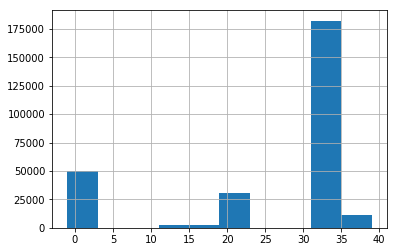

In [17]:
plot_hist_simple(best_action_result[:, 1])

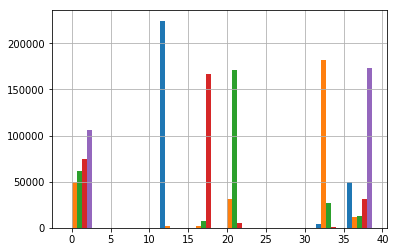

In [18]:
plot_hist_simple(best_action_result)